In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
def affine_jump_diffusion(Paths, Steps, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump):
    dt = T / Steps
    time = np.linspace(0, T, Steps + 1)
    X = np.zeros((Paths, Steps + 1))
    X[:, 0] = theta  # Initialize X at the mean level theta

    # Generate Brownian motion increments
    dW = np.random.normal(0, np.sqrt(dt), (Paths, Steps))

    # Generate Poisson jumps
    poisson_paths = np.random.poisson(lambda_jump * dt, (Paths, Steps))  # Jump occurrences
    Z = poisson_paths  # Poisson process as jump occurrences

    for i in range(Steps):
        # Generate jump sizes, ensuring they are within reasonable bounds
        Jumps = Z[:, i] * np.random.normal(mu_jump, sigma_jump, Paths)

        X[:, i + 1] = X[:, i] + kappa * (theta - X[:, i]) * dt + sigma * np.sqrt(np.maximum(0, X[:, i])) * dW[:, i] + Jumps
        X[:, i + 1] = np.maximum(0, X[:, i + 1])  # Reflective barrier at zero

    return X


In [ ]:
Paths, Steps, T = 1000, 252 *2, 2
kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump = 0.5, 0.02, 0.1, 0.5, 0.02, 0.02

In [ ]:
affine_jump_diffusion(Paths, Steps, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump)

array([[0.02      , 0.0211173 , 0.02108694, ..., 0.02125912, 0.02109167,
        0.02017051],
       [0.02      , 0.02104248, 0.02198483, ..., 0.0471026 , 0.04501667,
        0.04713271],
       [0.02      , 0.01904325, 0.01785617, ..., 0.03356605, 0.03221906,
        0.03122466],
       ...,
       [0.02      , 0.01986236, 0.01963729, ..., 0.00536645, 0.00551849,
        0.00684264],
       [0.02      , 0.02042968, 0.01979974, ..., 0.01335507, 0.01268053,
        0.01389309],
       [0.02      , 0.01888054, 0.0177529 , ..., 0.02650228, 0.02821088,
        0.02817165]])

In [ ]:
import pandas as pd
import requests

# Define FRED API key and URL for U.S. 10-Year Treasury yield
API_KEY = 'e8dd5a9101e31c8b991e39b6046212c9'
SERIES_ID = 'DGS10'  # 10-Year Treasury Constant Maturity Rate
BASE_URL = f"https://api.stlouisfed.org/fred/series/observations"

# Function to download interest rate data
def download_interest_rate(api_key, series_id, start_date="2022-10-18", end_date="2024-10-30"):
    params = {
        'api_key': api_key,
        'series_id': series_id,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date,
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()

    if 'observations' in data:
        observations = data['observations']
        df = pd.DataFrame(observations)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')  # Convert value to numeric
        df = df[['date', 'value']].dropna()  # Select relevant columns and drop NaN
        return df
    else:
        raise ValueError(f"Error fetching data: {data.get('error_message', 'Unknown error')}")

# Download data
try:
    rates_df = download_interest_rate(API_KEY, SERIES_ID)
    print(rates_df.head())
    rates_df.to_csv('interest_rates.csv', index=False)
    print("Data saved to 'interest_rates.csv'.")
except Exception as e:
    print(f"An error occurred: {e}")


        date  value
0 2022-10-18   4.01
1 2022-10-19   4.14
2 2022-10-20   4.24
3 2022-10-21   4.21
4 2022-10-24   4.25
Data saved to 'interest_rates.csv'.


In [ ]:
from scipy.optimize import minimize

In [ ]:
def calibration(Paths, Steps, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump, observed_data):
    X = affine_jump_diffusion(Paths, Steps, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump)

    # Define the objective function for optimization
    def objective(params):
        kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump = params
        simulated_data = affine_jump_diffusion(Paths, Steps, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump)
        return np.mean((np.mean(simulated_data, axis=0) - observed_data) ** 2)


    initial_params = [kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump]

    bounds = [
        (1e-3, 10.0),  # kappa
        (1e-3, 10.0),  # theta
        (1e-3, 5.0),   # sigma
        (1e-3, 2.0),   # lambda_jump
        (-2.0, 2.0),   # mu_jump
        (1e-3, 2.0)    # sigma_jump
    ]

    result = minimize(objective, initial_params, method='L-BFGS-B', bounds=bounds)

    calibrated_params = {
        "kappa": result.x[0],
        "theta": result.x[1],
        "sigma": result.x[2],
        "lambda_jump": result.x[3],
        "mu_jump": result.x[4],
        "sigma_jump": result.x[5]
    }
    final_error = result.fun
    # affine_jump_diffusion(calibrated_params).plot()
    return calibrated_params, final_error



In [ ]:
interest_rate = pd.read_csv('interest_rates.csv')

In [ ]:
interest_rate

,date,value
0,2022-10-18,4.01
1,2022-10-19,4.14
2,2022-10-20,4.24
3,2022-10-21,4.21
4,2022-10-24,4.25
...,...,...
505,2024-10-24,4.21
506,2024-10-25,4.25
507,2024-10-28,4.28
508,2024-10-29,4.28


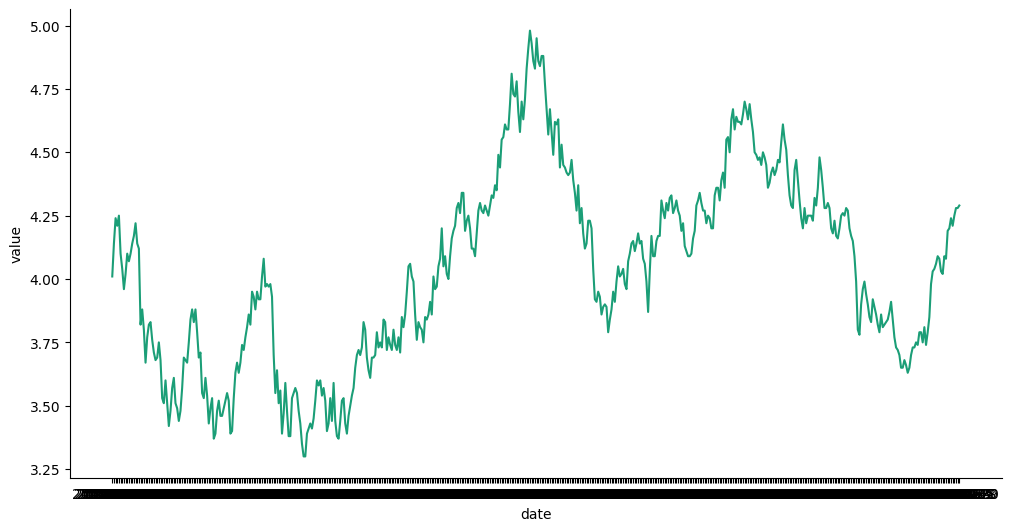

In [ ]:
# @title date vs value

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = interest_rate.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('value')

In [ ]:
step = len(interest_rate) - 1

In [ ]:
calibration(Paths, step, T, kappa, theta, sigma, lambda_jump, mu_jump, sigma_jump, interest_rate['value']/100)

({'kappa': 0.50000003857765,
  'theta': 0.020000000823544063,
  'sigma': 0.10000001444504483,
  'lambda_jump': 0.5000000026333028,
  'mu_jump': 0.020000019145355888,
  'sigma_jump': 0.02000002015657096},
 0.00018767707376224037)

In [ ]:
affine_jump_diffusion(Paths, Steps, T, )